[**Blueprints for Text Analysis Using Python**](https://github.com/blueprints-for-text-analytics-python/blueprints-text)  
Jens Albrecht, Sidharth Ramachandran, Christian Winkler

# Chapter 3:<div class='tocSkip'/>

# Scraping Websites and Extracting Data

## Remark<div class='tocSkip'/>

The code in this notebook differs slightly from the printed book. The Reuters website has changed significantly and is now obfuscated. For the illustractive examples we use the version from the Internet Archive. There are some utility functions which explain how to handle obfuscation though.

Moreover, several layout and formatting commands, like `figsize` to control figure size or subplot commands are removed in the book.

All of this is done to simplify the code in the book and put the focus on the important parts instead of formatting.

## Setup<div class='tocSkip'/>

Set directory locations. If working on Google Colab: copy files and install required libraries.

In [12]:
import sys, os
ON_COLAB = 'google.colab' in sys.modules

if ON_COLAB:
    GIT_ROOT = 'https://github.com/blueprints-for-text-analytics-python/blueprints-text/raw/master'
    os.system(f'wget {GIT_ROOT}/ch03/setup.py')

%run -i setup.py

You are working on a local system.
Files will be searched relative to "..".


## Load Python Settings<div class="tocSkip"/>

Common imports, defaults for formatting in Matplotlib, Pandas etc.

In [13]:
%run "$BASE_DIR/settings.py"

%reload_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = 'png'

# Blueprint: download and interpret robots.txt

In [14]:
import urllib.robotparser
rp = urllib.robotparser.RobotFileParser()
rp.set_url("https://www.reuters.com/robots.txt")
rp.read()

In [15]:
rp.can_fetch("*", "https://www.reuters.com/arc/outboundfeeds/news-sitemap/?outputType=xml")

True

In [16]:
rp.can_fetch("*", "https://www.reuters.com/finance/stocks/option")

False

# Blueprint: finding URLs from sitemap.xml

In [17]:
# might need to install xmltodict
import xmltodict
import requests

sitemap = xmltodict.parse(requests.get('https://www.reuters.com/arc/outboundfeeds/news-sitemap/?outputType=xml').text)

In [18]:
# just see some of the URLs
urls = [url["loc"] for url in sitemap["urlset"]["url"]]
print("\n".join(urls[0:3]))

https://www.reuters.com/world/europe/swedish-police-says-man-arrested-absentia-gothenburg-blast-2021-09-30/
https://www.reuters.com/world/europe/96-year-old-german-war-crimes-suspect-caught-after-hours-run-court-2021-09-30/
https://www.reuters.com/business/healthcare-pharmaceuticals/what-you-need-know-about-coronavirus-right-now-2021-09-30/


# Blueprint: finding URLs from RSS

Reuters removed its RSS feed after the book was published. We therefore use a saved copy from the Internet archive

In [19]:
# might need to install feedparser
import feedparser
feed = feedparser.parse('http://web.archive.org/web/20200613003232if_/http://feeds.reuters.com/Reuters/worldNews')

In [20]:
[(e.title, e.link) for e in feed.entries]

[('Mexico City to begin gradual exit from lockdown on Monday',
  'http://feeds.reuters.com/~r/Reuters/worldNews/~3/OQtkVdAqHos/mexico-city-to-begin-gradual-exit-from-lockdown-on-monday-idUSKBN23K00R'),
 ('Mexico reports record tally of 5,222 new coronavirus cases',
  'http://feeds.reuters.com/~r/Reuters/worldNews/~3/Rkz9j2G7lJU/mexico-reports-record-tally-of-5222-new-coronavirus-cases-idUSKBN23K00B'),
 ('Venezuela supreme court to swear in new electoral council leaders, government says',
  'http://feeds.reuters.com/~r/Reuters/worldNews/~3/cc3R5aq4Ksk/venezuela-supreme-court-to-swear-in-new-electoral-council-leaders-government-says-idUSKBN23J39T'),
 ("One-fifth of Britain's coronavirus patients were infected in hospitals: Telegraph",
  'http://feeds.reuters.com/~r/Reuters/worldNews/~3/1_7Wb0S_6-8/one-fifth-of-britains-coronavirus-patients-were-infected-in-hospitals-telegraph-idUSKBN23J382'),
 ('France to lift border controls for EU travellers on June 15',
  'http://feeds.reuters.com/~r/

In [21]:
[e.id for e in feed.entries]

['https://www.reuters.com/article/us-health-coronavirus-mexico-city/mexico-city-to-begin-gradual-exit-from-lockdown-on-monday-idUSKBN23K00R?feedType=RSS&feedName=worldNews',
 'https://www.reuters.com/article/us-health-coronavirus-mexico/mexico-reports-record-tally-of-5222-new-coronavirus-cases-idUSKBN23K00B?feedType=RSS&feedName=worldNews',
 'https://www.reuters.com/article/us-venezuela-politics/venezuela-supreme-court-to-swear-in-new-electoral-council-leaders-government-says-idUSKBN23J39T?feedType=RSS&feedName=worldNews',
 'https://www.reuters.com/article/us-health-coronavirus-britain-hospitals/one-fifth-of-britains-coronavirus-patients-were-infected-in-hospitals-telegraph-idUSKBN23J382?feedType=RSS&feedName=worldNews',
 'https://www.reuters.com/article/us-health-coronavirus-france-borders/france-to-lift-border-controls-for-eu-travellers-on-june-15-idUSKBN23J385?feedType=RSS&feedName=worldNews',
 'https://www.reuters.com/article/us-health-coronavirus-brazil/brazils-covid-19-deaths-sur

# Example: Downloading HTML pages with Python

In [34]:
%%time
s = requests.Session()
for url in urls[0:10]:
    # get the part after the last / in URL and use as filename
    file = url.split("/")[-1]
    
    r = s.get(url)
    with open(file, "w+b") as f:
        f.write(r.text.encode('utf-8'))

FileNotFoundError: [Errno 2] No such file or directory: ''

In [35]:
with open("urls.txt", "w+b") as f:
    f.write("\n".join(urls).encode('utf-8'))

# Blueprint: Extraction with regular expressions

We first have to download a single article

In [36]:
url = 'https://www.reuters.com/article/us-health-vaping-marijuana-idUSKBN1WG4KT'

file = url.split("/")[-1] + ".html"

r = requests.get(url)

with open(file, "w+") as f:
    f.write(r.text)

In [37]:
import re
with open(file, "r") as f:
    html = f.read()
    g = re.search(r'<title>(.*)</title>', html, re.MULTILINE|re.DOTALL)
    if g:
        print(g.groups()[0])

Banned in Boston: Without vaping, medical marijuana patients must adapt | Reuters


# Using an HTML parser for extraction

Reuters changed its content structure after the book was published. Unfortunately, they *obfuscated* the content so that the methods in the book don't work without massive changes.

In this notebook, we stick to the text in the book and download the articles from the Internet archive which still has the old HTML structure.

In [38]:
WA_PREFIX = "http://web.archive.org/web/20200118131624/"
html = s.get(WA_PREFIX + url).text

In [39]:
from bs4 import BeautifulSoup
soup = BeautifulSoup(html, 'html.parser')
soup.select("h1.ArticleHeader_headline")

[<h1 class="ArticleHeader_headline">Banned in Boston: Without vaping, medical marijuana patients must adapt</h1>]

## Blueprint: extracting the title/headline

In [40]:
soup.h1

<h1 class="ArticleHeader_headline">Banned in Boston: Without vaping, medical marijuana patients must adapt</h1>

In [41]:
soup.h1.text

'Banned in Boston: Without vaping, medical marijuana patients must adapt'

In [42]:
soup.title.text

'\n                Banned in Boston: Without vaping, medical marijuana patients must adapt - Reuters'

In [43]:
soup.title.text.strip()

'Banned in Boston: Without vaping, medical marijuana patients must adapt - Reuters'

## Blueprint: extracting the article text

In [44]:
soup.select_one("div.StandardArticleBody_body").text

'BOSTON (Reuters) - In the first few days of the four-month ban on all vaping products in Massachusetts, Laura Lee Medeiros, a medical marijuana patient, began to worry.\xa0 FILE PHOTO: An employee puts down an eighth of an ounce marijuana after letting a customer smell it outside the Magnolia cannabis lounge in Oakland, California, U.S. April 20, 2018. REUTERS/Elijah NouvelageThe 32-year-old massage therapist has a diagnosis of post-traumatic stress disorder (PTSD) from childhood trauma. To temper her unpredictable panic attacks, she relied on a vape pen and cartridges filled with the marijuana derivatives THC and CBD from state dispensaries. There are other ways to get the desired effect from  marijuana, and patients have filled dispensaries across the state in recent days to ask about edible or smokeable forms. But Medeiros has come to depend on her battery-powered pen, and wondered how she would cope without her usual supply of cartridges.  “In the midst of something where I’m on t

## Blueprint: extracting image captions

In [45]:
soup.select("div.StandardArticleBody_body figure")

[<figure class="Image_zoom" style="padding-bottom:"><div class="LazyImage_container LazyImage_dark" style="background-image:none"><img aria-label="FILE PHOTO: An employee puts down an eighth of an ounce marijuana after letting a customer smell it outside the Magnolia cannabis lounge in Oakland, California, U.S. April 20, 2018. REUTERS/Elijah Nouvelage" src="//web.archive.org/web/20200118131624im_/https://s3.reutersmedia.net/resources/r/?m=02&amp;d=20191001&amp;t=2&amp;i=1435991144&amp;r=LYNXMPEF9039L&amp;w=20"/><div class="LazyImage_image LazyImage_fallback" style="background-image:url(//web.archive.org/web/20200118131624im_/https://s3.reutersmedia.net/resources/r/?m=02&amp;d=20191001&amp;t=2&amp;i=1435991144&amp;r=LYNXMPEF9039L&amp;w=20);background-position:center center;background-color:inherit"></div></div><div aria-label="Expand Image Slideshow" class="Image_expand-button" role="button" tabindex="0"><svg focusable="false" height="18px" version="1.1" viewbox="0 0 18 18" width="18px"

Variant

In [46]:
soup.select("div.StandardArticleBody_body figure img")

[<img aria-label="FILE PHOTO: An employee puts down an eighth of an ounce marijuana after letting a customer smell it outside the Magnolia cannabis lounge in Oakland, California, U.S. April 20, 2018. REUTERS/Elijah Nouvelage" src="//web.archive.org/web/20200118131624im_/https://s3.reutersmedia.net/resources/r/?m=02&amp;d=20191001&amp;t=2&amp;i=1435991144&amp;r=LYNXMPEF9039L&amp;w=20"/>,
 <img src="//web.archive.org/web/20200118131624im_/https://s3.reutersmedia.net/resources/r/?m=02&amp;d=20191001&amp;t=2&amp;i=1435991145&amp;r=LYNXMPEF9039M"/>]

In [47]:
soup.select("div.StandardArticleBody_body figcaption")

[<figcaption><div class="Image_caption"><span>FILE PHOTO: An employee puts down an eighth of an ounce marijuana after letting a customer smell it outside the Magnolia cannabis lounge in Oakland, California, U.S. April 20, 2018. REUTERS/Elijah Nouvelage</span></div></figcaption>,
 <figcaption class="Slideshow_caption">Slideshow<span class="Slideshow_count"> (2 Images)</span></figcaption>]

## Blueprint: extracting the URL

In [48]:
soup.find("link", {'rel': 'canonical'})['href']

'http://web.archive.org/web/20200118131624/https://www.reuters.com/article/us-health-vaping-marijuana-idUSKBN1WG4KT'

In [49]:
soup.select_one("link[rel=canonical]")['href']

'http://web.archive.org/web/20200118131624/https://www.reuters.com/article/us-health-vaping-marijuana-idUSKBN1WG4KT'

## Blueprint: extracting list information (authors)

In [50]:
soup.find("meta", {'name': 'Author'})['content']

'Jacqueline Tempera'

Variant

In [51]:
sel = "div.BylineBar_first-container.ArticleHeader_byline-bar div.BylineBar_byline span"
soup.select(sel)

[<span><a href="/web/20200118131624/https://www.reuters.com/journalists/jacqueline-tempera" target="_blank">Jacqueline Tempera</a>, </span>,
 <span><a href="/web/20200118131624/https://www.reuters.com/journalists/jonathan-allen" target="_blank">Jonathan Allen</a></span>]

In [52]:
[a.text for a in soup.select(sel)]

['Jacqueline Tempera, ', 'Jonathan Allen']

## Blueprint: Extracting text of links (section)


In [53]:
soup.select_one("div.ArticleHeader_channel a").text

'Health News'

## Blueprint: Extracting reading time

In [54]:
soup.select_one("p.BylineBar_reading-time").text

'6 Min Read'

## Blueprint: extracting attributes (id)

In [55]:
soup.select_one("div.StandardArticle_inner-container")['id']

'USKBN1WG4KT'

Alternative: URL

## Blueprint: Extracting Attribution

In [56]:
soup.select_one("p.Attribution_content").text

'Reporting Jacqueline Tempera in Brookline and Boston, Massachusetts, and Jonathan Allen in New York; Editing by Frank McGurty and Bill Berkrot'

## Blueprint: Extracting Timestamp

In [57]:
ptime = soup.find("meta", { 'property': "og:article:published_time"})['content']
print(ptime)

2019-10-01T19:23:16+0000


In [58]:
from dateutil import parser
parser.parse(ptime)

datetime.datetime(2019, 10, 1, 19, 23, 16, tzinfo=tzutc())

In [59]:
parser.parse(soup.find("meta", { 'property': "og:article:modified_time"})['content'])

datetime.datetime(2019, 10, 1, 19, 23, 16, tzinfo=tzutc())

# Blueprint: Spidering

In [60]:
import requests
from bs4 import BeautifulSoup
import os.path
from dateutil import parser

def download_archive_page(page):
    filename = "page-%06d.html" % page
    if not os.path.isfile(filename):
        url = "https://www.reuters.com/news/archive/" + \
              "?view=page&page=%d&pageSize=10" % page
        r = requests.get(url)
        with open(filename, "w+") as f:
            f.write(r.text)

def parse_archive_page(page_file):
    with open(page_file, "r") as f:
        html = f.read()
    soup = BeautifulSoup(html, 'html.parser')
    hrefs = ["https://www.reuters.com" + a['href'] 
               for a in soup.select("article.story div.story-content a")]
    return hrefs

def download_article(url):
    # check if article already there
    filename = url.split("/")[-1] + ".html"
    if not os.path.isfile(filename):
        r = requests.get(url)
        with open(filename, "w+") as f:
            f.write(r.text)

def parse_article(article_file):
    def find_obfuscated_class(soup, klass):
        return soup.find_all(lambda tag: tag.has_attr("class") and (klass in " ".join(tag["class"])))
    
    with open(article_file, "r") as f:
        html = f.read()
    r = {}
    soup = BeautifulSoup(html, 'html.parser')
    r['url'] = soup.find("link", {'rel': 'canonical'})['href']
    r['id'] = r['url'].split("-")[-1]
    r['headline'] = soup.h1.text
    r['section'] = find_obfuscated_class(soup, "ArticleHeader-channel")[0].text
    
    r['text'] = "\n".join([t.text for t in find_obfuscated_class(soup, "Paragraph-paragraph")])
    r['authors'] = find_obfuscated_class(soup, "Attribution-attribution")[0].text
    r['time'] = soup.find("meta", { 'property': "og:article:published_time"})['content']
    return r

In [61]:
# download 10 pages of archive
for p in range(1, 10):
    download_archive_page(p)

UnicodeEncodeError: 'charmap' codec can't encode characters in position 33380-33381: character maps to <undefined>

In [62]:
# parse archive and add to article_urls
import glob

article_urls = []
for page_file in glob.glob("page-*.html"):
    article_urls += parse_archive_page(page_file)

In [63]:
# download articles
for url in article_urls:
    download_article(url)

In [64]:
# arrange in pandas DataFrame
import pandas as pd

df = pd.DataFrame()
for article_file in glob.glob("*-id???????????.html"):
    df = df.append(parse_article(article_file), ignore_index=True)
df['time'] = pd.to_datetime(df.time)

In [65]:
df

,url,id,headline,section,text,authors,time
0,https://www.reuters.com/article/us-health-vaping-marijuana-idUSKBN1WG4KT,idUSKBN1WG4KT,"Banned in Boston: Without vaping, medical marijuana patients must adapt",Healthcare & Pharma,"BOSTON (Reuters) - In the first few days of the four-month ban on all vaping products in Massachusetts, Laura Lee Medeiros, a medical marijuana patient, began to worry.\nThe 32-year-old massage th...","Reporting Jacqueline Tempera in Brookline and Boston, Massachusetts, and Jonathan Allen in New York; Editing by Frank McGurty and Bill Berkrot",2019-10-01 18:35:04+00:00


In [66]:
df.sort_values("time")

,url,id,headline,section,text,authors,time
0,https://www.reuters.com/article/us-health-vaping-marijuana-idUSKBN1WG4KT,idUSKBN1WG4KT,"Banned in Boston: Without vaping, medical marijuana patients must adapt",Healthcare & Pharma,"BOSTON (Reuters) - In the first few days of the four-month ban on all vaping products in Massachusetts, Laura Lee Medeiros, a medical marijuana patient, began to worry.\nThe 32-year-old massage th...","Reporting Jacqueline Tempera in Brookline and Boston, Massachusetts, and Jonathan Allen in New York; Editing by Frank McGurty and Bill Berkrot",2019-10-01 18:35:04+00:00


IndexError: index 0 is out of bounds for axis 0 with size 0

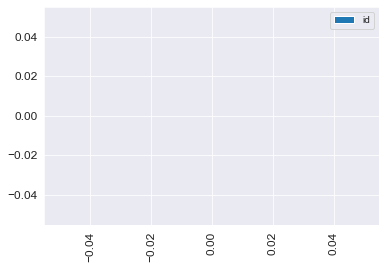

In [67]:
%matplotlib inline
df[df["time"]>='2020-01-01'].set_index("time").resample('D').agg({'id': 'count'}).plot.bar()

# Blueprint Density extraction

In [68]:
from readability import Document

doc = Document(html)
doc.title()

ModuleNotFoundError: No module named 'readability'

In [69]:
doc.short_title()

NameError: name 'doc' is not defined

In [ ]:
doc.summary()

In [ ]:
doc.url

In [ ]:
density_soup = BeautifulSoup(doc.summary(), 'html.parser')
density_soup.body.text

# Blueprint: Scrapy

Unfortunately, the code for `scrapy` cannot be changed easily. One more argument for using *up to date* separate libraries. In this version, it still collects the titles of the articles but not more.

In [ ]:
# might need to install scrapy
import scrapy
import logging


class ReutersArchiveSpider(scrapy.Spider):
    name = 'reuters-archive'
    
    custom_settings = {
        'LOG_LEVEL': logging.WARNING,
        'FEED_FORMAT': 'json',
        'FEED_URI': 'reuters-archive.json'
    }
    
    start_urls = [
        'https://www.reuters.com/news/archive/',
    ]

    def parse(self, response):
        for article in response.css("article.story div.story-content a"):
            yield response.follow(article.css("a::attr(href)").extract_first(), self.parse_article)

        next_page_url = response.css('a.control-nav-next::attr(href)').extract_first()
        if (next_page_url is not None) & ('page=2' not in next_page_url):
            yield response.follow(next_page_url, self.parse)

    def parse_article(self, response):
        yield {
          'title': response.css('h1::text').extract_first().strip(),
        }

In [ ]:
# this can be run only once from a Jupyter notebook due to Twisted
from scrapy.crawler import CrawlerProcess
process = CrawlerProcess()

process.crawl(ReutersArchiveSpider)
process.start()

In [ ]:
glob.glob("*.json")

In [ ]:
!cat 'reuters-archive.json'